In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X = ((X / 255.) - .5) * 2

In [19]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=123, stratify=y_temp)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid = torch.tensor(y_valid, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [20]:
class NeuralNetMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [40]:
def one_hot_encode(y, num_classes):
    y_onehot = torch.zeros(y.size(0), num_classes, device=y.device)
    y_onehot[torch.arange(y.size(0)), y] = 1
    return y_onehot

def train_model(model, criterion, optimizer, X_train, y_train, X_valid, y_valid, num_epochs, batch_size):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    train_aucs = []
    valid_aucs = []

    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_loss = 0.0
        for i in range(0, X_train.size(0), batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]
            y_batch_onehot = one_hot_encode(y_batch, output_size)

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch_onehot)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            valid_outputs = model(X_valid)

            train_loss = criterion(train_outputs, one_hot_encode(y_train, output_size)).item()
            valid_loss = criterion(valid_outputs, one_hot_encode(y_valid, output_size)).item()

            train_preds = torch.argmax(train_outputs, dim=1)
            valid_preds = torch.argmax(valid_outputs, dim=1)

            # Move tensors to CPU and convert to NumPy arrays
            y_train_np = y_train.cpu().numpy()
            train_preds_np = train_preds.cpu().numpy()
            y_valid_np = y_valid.cpu().numpy()
            valid_preds_np = valid_preds.cpu().numpy()

            # Compute Accuracy
            train_accuracy = accuracy_score(y_train_np, train_preds_np)
            valid_accuracy = accuracy_score(y_valid_np, valid_preds_np)

            # Compute AUC
            train_auc = roc_auc_score(
                one_hot_encode(y_train, output_size).cpu().numpy(), train_outputs.cpu().numpy(),
                average="macro", multi_class="ovr"
            )
            valid_auc = roc_auc_score(
                one_hot_encode(y_valid, output_size).cpu().numpy(), valid_outputs.cpu().numpy(),
                average="macro", multi_class="ovr"
            )

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        train_aucs.append(train_auc)
        valid_aucs.append(valid_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}, "
              f"Train Acc: {train_accuracy:.6f}, Valid Acc: {valid_accuracy:.6f}, "
              f"Train AUC: {train_auc:.6f}, Valid AUC: {valid_auc:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, train_aucs, valid_aucs

In [41]:
input_size = 28 * 28
hidden_size1 = 500
hidden_size2 = 500
output_size = 10
model = NeuralNetMLP(input_size, hidden_size1, hidden_size2, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

num_epochs = 100
batch_size = 100

train_losses, valid_losses, train_accuracies, valid_accuracies, train_aucs, valid_aucs = train_model(
    model, criterion, optimizer, X_train, y_train, X_valid, y_valid, num_epochs, batch_size
)

Epoch [1/100], Train Loss: 0.089941, Valid Loss: 0.089941, Train Acc: 0.112526, Valid Acc: 0.112551, Train AUC: 0.574419, Valid AUC: 0.577254
Epoch [2/100], Train Loss: 0.089885, Valid Loss: 0.089885, Train Acc: 0.112526, Valid Acc: 0.112551, Train AUC: 0.690214, Valid AUC: 0.692685
Epoch [3/100], Train Loss: 0.089819, Valid Loss: 0.089818, Train Acc: 0.112526, Valid Acc: 0.112551, Train AUC: 0.774688, Valid AUC: 0.776313
Epoch [4/100], Train Loss: 0.089761, Valid Loss: 0.089760, Train Acc: 0.127679, Valid Acc: 0.128163, Train AUC: 0.832760, Valid AUC: 0.833917
Epoch [5/100], Train Loss: 0.089695, Valid Loss: 0.089694, Train Acc: 0.112526, Valid Acc: 0.112551, Train AUC: 0.870494, Valid AUC: 0.871486
Epoch [6/100], Train Loss: 0.089638, Valid Loss: 0.089637, Train Acc: 0.112704, Valid Acc: 0.112755, Train AUC: 0.894055, Valid AUC: 0.895007
Epoch [7/100], Train Loss: 0.089545, Valid Loss: 0.089543, Train Acc: 0.113622, Valid Acc: 0.114184, Train AUC: 0.908658, Valid AUC: 0.909535
Epoch 

## Evaluating the neural network performance

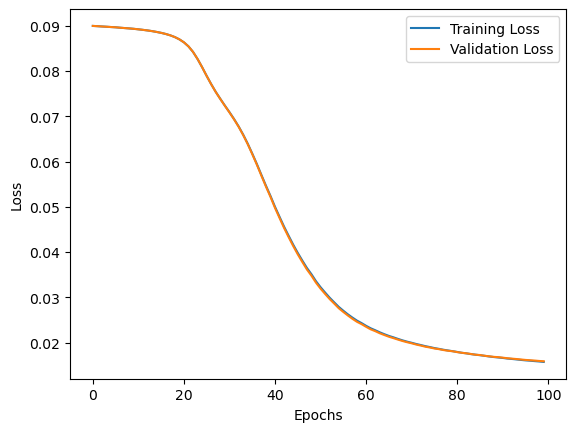

In [42]:
plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(len(valid_losses)), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

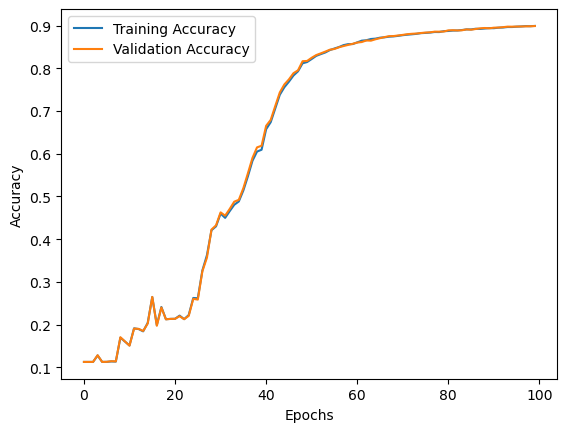

In [43]:
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
plt.plot(range(len(valid_accuracies)), valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

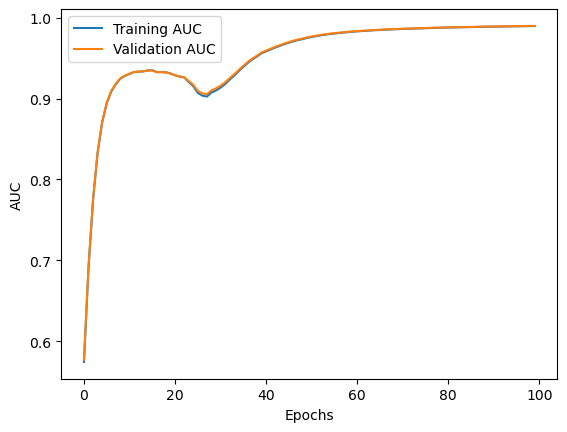

In [44]:
plt.plot(range(len(train_aucs)), train_aucs, label='Training AUC')
plt.plot(range(len(valid_aucs)), valid_aucs, label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [45]:
# Evaluate on Test Data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_preds = torch.argmax(test_outputs, dim=1)
    test_auc = roc_auc_score(
        one_hot_encode(y_test, output_size).cpu().numpy(), test_outputs.cpu().numpy(), average="macro", multi_class="ovr"
    )
    test_accuracy = accuracy_score(y_test.cpu(), test_preds.cpu())
    test_loss = criterion(test_outputs, one_hot_encode(y_test, output_size)).item()

print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy*100:.6f}")
print(f"Test AUC: {test_auc:.6f}")

Test Loss (MSE): 0.016207
Test Accuracy: 89.742857
Test AUC: 0.988698
